#**Neural Machine Translation**
###NMT is the use of neural network models to learn a statistical model for machine translation.




The language translation model that we are going to develop will translate English sentences into their French language counterparts.To develop such a model, we need a dataset that contains English sentences and their French translations.

The English-French Dataset is taken from:  http://www.manythings.org/anki/

This model will be build using the keras library. 


LSTM model will be used to train on the dataset.

**Steps:**
1. Data Exploration
2. Data cleaning and preprocessing
3. Word to Vector / Tokenization
4. Defining the Encoder
5. Defining the Decoder
6. Training the model
7. Optimization
8. Calculating accuracy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the libraries

In [ ]:
import pandas as pd 
import nltk            
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.layers.embeddings import  Embedding
from keras.layers import LSTM, Dense, Input
from keras.models import Model
from sklearn.model_selection import train_test_split

##**Collecting the data**


In [ ]:
 data = pd.read_csv('/content/drive/MyDrive/Datasets/Hindi_English_Truncated_Corpus.csv', encoding='utf-8')
 data.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


##**Data Exploration**

In [ ]:
data['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [ ]:
data = data[data['source']=='ted']

Checking the data

In [ ]:
data.head(10)    #first 5 values

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
13,ted,So there is some sort of justice,तो वहाँ न्याय है
23,ted,This changed slowly,धीरे धीरे ये सब बदला
26,ted,were being produced.,उत्पन्न नहीं कि जाती थी.
30,ted,"And you can see, this LED is going to glow.","और जैसा आप देख रहे है, ये एल.ई.डी. जल उठेगी।"
32,ted,to turn on the lights or to bring him a glass ...,"लाईट जलाने के लिए या उनके लिए पानी लाने के लिए,"
35,ted,Can you imagine saying that?,क्या आप ये कल्पना कर सकते है


In [ ]:
data.tail(10)    #last 5 values

,source,english_sentence,hindi_sentence
127575,ted,it requires that all of us have the courage an...,"हम सब में हिम्मत और धैर्य हो,"
127583,ted,"need not be, so-called, jugaad, need not be so...",या फ़िर सिर्फ़ जुगाड कर के किसी तरह बना दिये ग...
127588,ted,it keeps forwarding you to more and more advan...,आपको और ज्यादा आगे के स्तर पर ये अपने आप लेता ...
127589,ted,Let's figure out how long it takes a race car ...,देखते है कि रेस कार एक निश्चित समय मे कितनी दू...
127592,ted,Because when you are a developing country,क्योंकि जब आप एक विकासशील देश हैं
127595,ted,is if we want that to become our reality -,अगर हम चाहते हैं कि यह वास्तविकता बने -
127597,ted,Africa has not done bad.,अफ़्रीका ने कुछ गलती नहीं की है।
127598,ted,Thank you.,धन्यवाद |
127603,ted,and put it in our cheeks.,और अपने गालों में डाल लेते हैं।
127606,ted,They've just won four government contracts to ...,हाल ही में उन्हें सरकारी ठेका मिला है करीब सौ ...


Shape of data

In [ ]:
data.shape

(39881, 3)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39881 entries, 0 to 127606
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            39881 non-null  object
 1   english_sentence  39881 non-null  object
 2   hindi_sentence    39881 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Checking if the dataset has null values.

In [ ]:
data.isnull().sum()               #sum of all null values

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [ ]:
data.columns = ['source','English', 'Hindi']
data.head()

,source,English,Hindi
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
13,ted,So there is some sort of justice,तो वहाँ न्याय है


In [ ]:
data = data[~pd.isnull(data['English'])]

Checking if the dataset has duplicate values

In [ ]:
data.duplicated().sum()   #Words with more than one translation

1078

In [ ]:
data.drop_duplicates(inplace = True)
data = data.reset_index()
data.drop('index', axis = 1, inplace = True)

##**Data Preprocessing**

###Data cleaning:

1.   Remove the punctuation.
2.   Convert them into lower form.
3.   Removing the digits.
4.   Removing quotes.
5.   Removing extra spaces.
6.   Adding start and end tokens to target sentence.



In [ ]:
def clean(tokens):
  punct = string.punctuation
  h = '२३०८१५७९४६'
 
  for z in h:
    if z in tokens:
      tokens = tokens.replace(z,'')        # replacing the hindi digits with ''


  if "'" in tokens:
    tokens = tokens.replace("'",'')        # replacing the quotes with ''

  for z in punct:
    if z in tokens:
      tokens = tokens.replace(z,'')        # replacing the punctuation with ''

  for z in tokens.split():
    if z.isnumeric():                      # replacing the digits with ''
      tokens = tokens.replace(z,'')

  tokens = tokens.strip()                  # removing spaces
                
  tokens = tokens.lower()                  # converting the string into lower form
  return tokens

In [ ]:
clean1=[]
a = data['English']
b = data['Hindi']
for i in range(len(a)):
  clean1.append((clean(a[i]),clean(b[i])))          #applying the function to both 'English' and 'Hindi'
clean1

[('politicians do not have permission to do what needs to be done',
  'राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करने कि अनुमति नहीं है'),
 ('id like to tell you about one such child',
  'मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी'),
 ('what we really mean is that theyre bad at not paying attention',
  'हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते'),
 ('and who are we to say even that they are wrong',
  'और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं'),
 ('so there is some sort of justice', 'तो वहाँ न्याय है'),
 ('this changed slowly', 'धीरे धीरे ये सब बदला'),
 ('were being produced', 'उत्पन्न नहीं कि जाती थी'),
 ('and you can see this led is going to glow',
  'और जैसा आप देख रहे है ये एलईडी जल उठेगी।'),
 ('to turn on the lights or to bring him a glass of water',
  'लाईट जलाने के लिए या उनके लिए पानी लाने के लिए'),
 ('can you imagine saying that', 'क्या आप ये कल्पना कर सकते है'),
 ('three this is a good road in  right near where our factory is located',
  'तीसरी ये हमारी फ़

###Converting the list into DataFrame

In [ ]:
data = pd.DataFrame(clean1)
data.columns = ['English', 'Hindi']

In [ ]:
data['Hindi'] = data['Hindi'].apply(lambda x : 'Start_ '+ x + ' _End')   # Adding start and end to sentence

In [ ]:
data.head()

,English,Hindi
0,politicians do not have permission to do what ...,Start_ राजनीतिज्ञों के पास जो कार्य करना चाहिए...
1,id like to tell you about one such child,Start_ मई आपको ऐसे ही एक बच्चे के बारे में बता...
2,what we really mean is that theyre bad at not ...,Start_ हम ये नहीं कहना चाहते कि वो ध्यान नहीं ...
3,and who are we to say even that they are wrong,Start_ और हम होते कौन हैं यह कहने भी वाले कि व...
4,so there is some sort of justice,Start_ तो वहाँ न्याय है _End


In [ ]:
data.tail()

,English,Hindi
38798,because when you are a developing country,Start_ क्योंकि जब आप एक विकासशील देश हैं _End
38799,is if we want that to become our reality,Start_ अगर हम चाहते हैं कि यह वास्तविकता बने _End
38800,africa has not done bad,Start_ अफ़्रीका ने कुछ गलती नहीं की है। _End
38801,and put it in our cheeks,Start_ और अपने गालों में डाल लेते हैं। _End
38802,theyve just won four government contracts to b...,Start_ हाल ही में उन्हें सरकारी ठेका मिला है क...


###Calculating unique words

In [ ]:
def words(value):
  set1 = set()
  for j in value:
    for i in j.split():
      if i not in set1:
        set1.add(i)
  return set1

In [ ]:
eng = words(data['English'])
hindi = words(data['Hindi'])

In [ ]:
eng_vocab = len(words(data['English']))
eng_vocab

17459

In [ ]:
hindi_vocab = len(words(data['Hindi']))
hindi_vocab

22306

###Finding maximum length of string (on total number of words)

English

In [ ]:
count1 = []
for i in range(len(data['Hindi'])):
  count1.append(len((data['English'][i]).split()))
max_input_length = max(count1)
max_input_length

21

Hindi

In [ ]:
count2 = []
for i in range(len(data['English'])):
  count2.append(len((data['Hindi'][i]).split()))
max_output_length = max(count2)
max_output_length

32

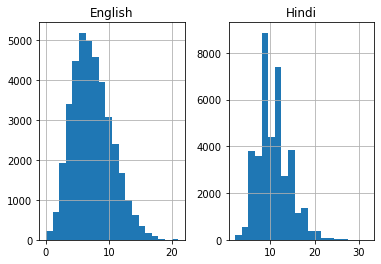

In [ ]:
graph = pd.DataFrame({'English':count1, 'Hindi':count2})
graph.hist(bins = 20)
plt.show()

The maximum length in English Dataset is 21

The maximum length in Hindi Dataset is 31.


In [ ]:
X, y = data['English'], data['Hindi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
X_train.shape, X_test.shape

((32982,), (5821,))

Making a dictionary of words to index

In [ ]:
input_token_index = dict([(word, i+1) for i, word in enumerate(sorted(list(eng)))])                # starting from i+1 i.e. 1 because 0 for padding
target_token_index = dict([(word, i+1) for i, word in enumerate(sorted(list(hindi)))])
list(input_token_index.keys())[155],list(input_token_index.values())[155], list(target_token_index.keys())[1200], list(target_token_index.values())[1200]

('abstract', 156, 'अफ़्रीकावासी', 1201)

Making a dictionary of index to words

In [ ]:
rev_input_token_index = dict([(i+1, word) for i, word in enumerate(sorted(list(eng)))])               
rev_target_token_index = dict([(i+1, word) for i, word in enumerate(sorted(list(hindi)))])
list(rev_input_token_index.keys())[155],list(rev_input_token_index.values())[155], list(rev_target_token_index.keys())[1200], list(rev_target_token_index.values())[1200]

(156, 'abstract', 1201, 'अफ़्रीकावासी')

Generating encoder input, decoder input, decoder target. This invaolves padding since we are using numpy arrays.

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = batch_size):
    
    while True:       # to loop with increment in batches

        for j in range(0, len(X), batch_size):          # here value of j will be len(X)/batch_size

            # Generating numpy arrays
            encoder_input_data = np.zeros((batch_size, max_input_length),dtype='float32')   # 2d array with rows= batchsize, col = max_input_length
            decoder_input_data = np.zeros((batch_size, max_output_length),dtype='float32')  
             
            # 3d array because we have to one-hot encode them. 
            decoder_target_data = np.zeros((batch_size, max_output_length, num_decoder_tokens),dtype='float32')

            # this is loop for seperate inputs and output. Using zip to calculate simultaneously for input and output.
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):

                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # putting the index of the word at the given position in array.

                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:              # we donot have to include END token, so len-1
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq

                    if t>0:        # we donot have to include START token, so t>0
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

##Building the model

To make predictions, the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer.

In [ ]:
latent_dim = 256
num_encoder_tokens = eng_vocab +1
num_decoder_tokens = hindi_vocab +1

In [ ]:
encoder_inputs = Input(shape=(None,))
embedding_layer = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, h, c = encoder_lstm(embedding_layer)
encoder_states = [h, c]

In [ ]:
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(num_decoder_tokens,latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

In [ ]:
decoder_dense = Dense(num_decoder_tokens, activation='softmax', )
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    4469760     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 256)    5710592     input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
257/257 [==============================] - 131s 384ms/step - loss: 2.0997 - accuracy: 0.0339 - val_loss: 1.9867 - val_accuracy: 0.0375
Epoch 2/50
257/257 [==============================] - 97s 379ms/step - loss: 1.9533 - accuracy: 0.0377 - val_loss: 1.9758 - val_accuracy: 0.0390
Epoch 3/50
257/257 [==============================] - 96s 373ms/step - loss: 1.9316 - accuracy: 0.0393 - val_loss: 1.9493 - val_accuracy: 0.0406
Epoch 4/50
257/257 [==============================] - 98s 380ms/step - loss: 1.9068 - accuracy: 0.0408 - val_loss: 1.9423 - val_accuracy: 0.0411
Epoch 5/50
257/257 [==============================] - 95s 370ms/step - loss: 1.8876 - accuracy: 0.0423 - val_loss: 1.9251 - val_accuracy: 0.0436
Epoch 6/50
257/257 [==============================] - 96s 374ms/step - loss: 1.8661 - accuracy: 0.0441 - val_loss: 1.9150 - val_accuracy: 0.0445
Epoch 7/50
257/257 [==============================] - 96s 375ms/step - loss: 1.8454 - accuracy: 0.0455 - val_loss: 1.9030 - val_a

Fro the Inference Model

In [ ]:
# We call input for both hidden state and cell state 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding = Embedding(num_decoder_tokens,latent_dim)
dec_emb2 = decoder_embedding(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    inputs  = [decoder_inputs] + decoder_states_inputs,
    outputs = [decoder_outputs2] + decoder_states2)


In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['Start_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:                  
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)  # we start the llop, the first value being START, its h state will be predicted
                                                                                  # output and input as described above in decoder_model

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])                  # this is to return the max index in the z axis, which represents 
                                                                                  # vocab index axis, to check which index has 1.

        sampled_char = rev_target_token_index[sampled_token_index]             # substituting the digit with corresponding character
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_End' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: so instead of having starch
Actual Hindi Translation:  स्टार्च मादी की जगह 
Predicted Hindi Translation:  स्टार्च मादी है 
